In [1]:
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
%matplotlib notebook
from main import *

In [2]:
#Extracting the SS coverages previously saved and extracted from kMC files
ss_COVG_NONLAT = pd.read_csv('SS_Covg_nonLat.csv')
ss_COVG_LAT = pd.read_csv('SS_Covg_Lat.csv')

In [3]:
#Isolating pressures and ss coverages
Prs_non_lat = ss_COVG_NONLAT.iloc[:,0].to_numpy()
Prs_lat = ss_COVG_LAT.iloc[:,0].to_numpy()
ss_covg_non_lat = ss_COVG_NONLAT.iloc[:,1].to_numpy()
ss_covg_lat = ss_COVG_LAT.iloc[:,1].to_numpy()

In [4]:
#Simulation times from each kMC simulation
t0,tf = 0,750.000000000102

In [5]:
%%time
#Performing SS MIKI MKM simulations for non lateral case
from main import *
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.Thermo_Constraint = 'OFF'
MKM.set_limits_of_integration(t0,tf)
MKM.rate_const_correction='None'
MKM_SS_covg_NONLAT = []
Prs = Prs_non_lat
for i in np.arange(len(Prs)):
    MKM.set_rxnconditions(Pr=[Prs[i]])
    MKM_SS_covg_NONLAT = np.append(MKM_SS_covg_NONLAT,MKM.get_SS_coverages(print_warning=False)[0])

Mass is conserved. 

CPU times: user 2.7 s, sys: 14.8 ms, total: 2.72 s
Wall time: 2.72 s


<IPython.core.display.Javascript object>


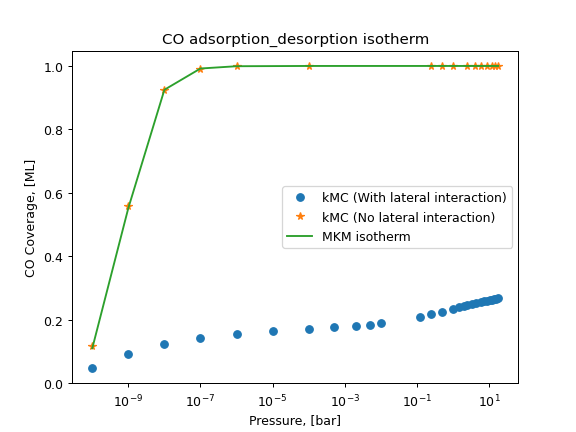

In [6]:
plt.figure()
plt.semilogx(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.semilogx(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.semilogx(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
# plt.semilogx(Prs,MKM_SS_covg_LAT,'-',label='MKM isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()

In [7]:
# For lateral only
##Step 1: Calculating Ki based on isotherm equation
Ki_lateral = []
for i in np.arange(len(Prs_lat)):
    Ki_lateral.append(ss_covg_lat[i]/((1-ss_covg_lat[i]) * Prs_lat[i]))
    
##Step 2: Calculating fi(theta)
Keq = MKM.k[0]/MKM.k[1]
fi_theta = []
for i in np.arange(len(Prs_lat)):
    fi_theta.append(Ki_lateral[i]/Keq)
    
##Therefore need to train ML model (for lateral interactions considered) where x is theta and y is fi_theta
##Step 3: MLM model
print('For Lateral:\n')
print('Pressure, SS_coverage_CO, K_from_isoeqn, f(theta)')
print(np.array([Prs_lat,ss_covg_lat,Ki_lateral,fi_theta]).T)

For Lateral:

Pressure, SS_coverage_CO, K_from_isoeqn, f(theta)
[[1.00000000e-10 4.63296155e-02 4.85803232e+08 3.94275087e-01]
 [1.00000000e-09 9.11109711e-02 1.00244329e+08 8.13577165e-02]
 [1.00000000e-08 1.21996393e-01 1.38947485e+07 1.12768973e-02]
 [1.00000000e-07 1.43216148e-01 1.67155517e+06 1.35662448e-03]
 [1.00000000e-06 1.55425457e-01 1.84028110e+05 1.49356148e-04]
 [1.00000000e-05 1.63325156e-01 1.95207442e+04 1.58429228e-05]
 [1.00000000e-04 1.70388884e-01 2.05384042e+03 1.66688498e-06]
 [5.00000000e-04 1.75406734e-01 4.25438192e+02 3.45283170e-07]
 [2.00000000e-03 1.80016145e-01 1.09768104e+02 8.90871566e-08]
 [5.00000000e-03 1.84291328e-01 4.51855752e+01 3.66723509e-08]
 [1.00000000e-02 1.88856113e-01 2.32826895e+01 1.88960958e-08]
 [1.25000000e-01 2.08986241e-01 2.11360411e+00 1.71538884e-09]
 [2.50000000e-01 2.17408512e-01 1.11122350e+00 9.01862547e-10]
 [5.00000000e-01 2.25479268e-01 5.82242045e-01 4.72544269e-10]
 [1.00000000e+00 2.34419844e-01 3.06198955e-01 2.48509

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()
scaler.fit(np.array(Ki_lateral).reshape(-1, 1))
Ki_lateral = scaler.transform(np.array(Ki_lateral).reshape(-1, 1))
data = np.array([ss_covg_lat, Ki_lateral[:,0]]).T
columns = ['theta', 'Ki']
df = pd.DataFrame(data = data, columns = columns)
df.head()


# data = np.array([ss_covg_lat, Ki_lateral]).T
# columns = ['theta', 'Ki']
# df = pd.DataFrame(data = data, columns = columns)
# df.head()

,theta,Ki
0,0.046330,1.000000
1,0.091111,0.206348
2,0.121996,0.028602
3,0.143216,0.003441
4,0.155425,0.000379


<IPython.core.display.Javascript object>


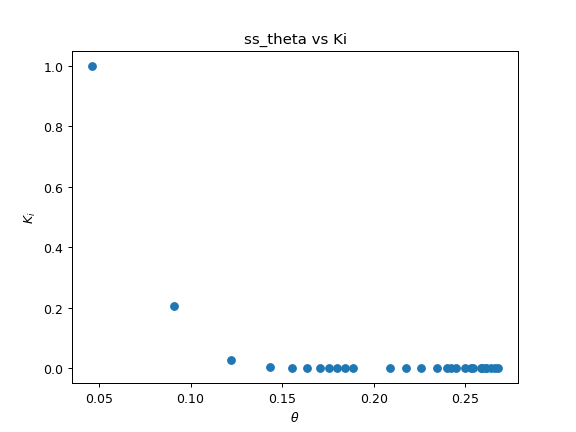

Text(0.5, 0, '$\\theta$')

In [9]:
plt.figure(dpi = 100)
plt.title('ss_theta vs Ki')
plt.scatter(df['theta'], df['Ki'])
plt.ylabel(r'$K_i$')
plt.xlabel(r'$\theta$')

In [10]:
X = df[['theta']]
y = df['Ki']

In [11]:
import sys 
import os
sys.path.append('/Users/klkusima/juliaup/bin')
sys.path.append('/Users/klkusima/brew/Cellar/juliaup/1.11.22/bin')
# os.environ['PATH'] += os.pathsep +'/Users/klkusima/.juliaup/bin'
os.environ['PATH'] += os.pathsep +'/Users/klkusima/juliaup/bin/'
os.environ['PATH'] += os.pathsep +'/Users/klkusima/brew/Cellar/juliaup/1.11.22/bin'
import julia

In [12]:
import numpy as np
from pysr import pysr, best

# Learn equations
from pysr import PySRRegressor

model = PySRRegressor(
    niterations=40,  # < Increase me for better results
    binary_operators=["+", "*", "/", "-"],
    unary_operators=[
        "exp",
        "inv(x) = 1/x",
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
)

In [13]:
%%time
import time
start_time = time.time()
reg = model.fit(X, y)
end_time = time.time()
elapsed_time = end_time - start_time
print("\nElapsed Model Training Time: \n", elapsed_time, "seconds \n", elapsed_time/60, "minutes")

/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


ImportError: 
    Required dependencies are not installed or built.  Run the following command in your terminal:
        python3 -m pysr install
    

In [14]:
import pysr
import sys, os
print(os.environ["PATH"])
sys.path.insert(0, os.path.abspath('/Users/klkusima/juliaup/bin'))
sys.path.insert(0, os.path.abspath('/Users/klkusima/brew/Cellar/juliaup/1.11.22/bin'))

/Users/klkusima/opt/anaconda3/bin:/Users/klkusima/brew/bin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/opt/X11/bin:/usr/local/munki:/Users/klkusima/Programs/cp2k/9.1/exe/Darwin-gfortran:/Users/klkusima/juliaup/bin/:/Users/klkusima/brew/Cellar/juliaup/1.11.22/bin


In [15]:
pysr.install()

[ Info: Julia version info


Julia Version 1.9.3
Commit bed2cd540a1 (2023-08-24 14:43 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: macOS (arm64-apple-darwin22.4.0)
  uname: Darwin 23.0.0 Darwin Kernel Version 23.0.0: Fri Sep 15 14:41:34 PDT 2023; root:xnu-10002.1.13~1/RELEASE_ARM64_T8103 x86_64 i386
  CPU: Apple M1: 
              speed         user         nice          sys         idle          irq
       #1  2400 MHz     730020 s          0 s     433161 s    2678801 s          0 s
       #2  2400 MHz     666336 s          0 s     400957 s    2777819 s          0 s
       #3  2400 MHz     592247 s          0 s     338224 s    2921755 s          0 s
       #4  2400 MHz     541361 s          0 s     289999 s    3028379 s          0 s
       #5  2400 MHz    1013949 s          0 s     197664 s    2654035 s          0 s
       #6  2400 MHz     411215 s          0 s     106000 s    3350786 s          0 s
       #7  2400 MHz     240330 s          0 s      48205 s    3590007 s         

[ Info: Julia executable: /Users/klkusima/opt/anaconda3/share/pysr/depot/juliaup/julia-1.9.3+0.aarch64.apple.darwin14/bin/julia
[ Info: Trying to import PyCall...
ERROR: LoadError: PyCall not properly installed. Please run Pkg.build("PyCall")
Stacktrace:
 [1] error(s::String)
   @ Base ./error.jl:35
 [2] top-level scope
   @ ~/opt/anaconda3/share/pysr/depot/packages/PyCall/ilqDX/src/startup.jl:44
 [3] include(mod::Module, _path::String)
   @ Base ./Base.jl:457
 [4] include(x::String)
   @ PyCall ~/opt/anaconda3/share/pysr/depot/packages/PyCall/ilqDX/src/PyCall.jl:1
 [5] top-level scope
   @ ~/opt/anaconda3/share/pysr/depot/packages/PyCall/ilqDX/src/PyCall.jl:38
 [6] include
   @ ./Base.jl:457 [inlined]
 [7] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt128}}, source::String)
   @ Base ./loading.jl:2049
 [8] top-level scope
   @ stdin:3
in expressi

PyCallInstallError: Installing PyCall failed.

** Important information from Julia may be printed before Python's Traceback **

Some useful information may also be stored in the build log file
`~/.julia/packages/PyCall/*/deps/build.log`.


In [12]:
import os
print(os.environ["PATH"])

/Users/klkusima/opt/anaconda3/bin:/Users/klkusima/brew/bin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/opt/X11/bin:/usr/local/munki:/Users/klkusima/Programs/cp2k/9.1/exe/Darwin-gfortran:/Users/klkusima/.juliaup/bin:/Users/klkusima/.juliaup/bin/julialauncher


In [10]:
os.environ['PATH'] += os.pathsep +'/Users/klkusima/.juliaup/bin'
os.environ['PATH'] += os.pathsep +'/Users/klkusima/.juliaup/bin/julialauncher'
print(os.environ["PATH"])

/Users/klkusima/opt/anaconda3/bin:/Users/klkusima/brew/bin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/opt/X11/bin:/usr/local/munki:/Users/klkusima/Programs/cp2k/9.1/exe/Darwin-gfortran:/Users/klkusima/.juliaup/bin:/Users/klkusima/.juliaup/bin/julialauncher


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicRegressor
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sympy import *
from sklearn.utils.random import check_random_state
import graphviz
import time

In [9]:
data = np.array([ss_covg_lat, Ki_lateral]).T
columns = ['theta', 'Ki']
df = pd.DataFrame(data = data, columns = columns)
df.head()

,theta,Ki
0,0.046330,4.858032e+08
1,0.091111,1.002443e+08
2,0.121996,1.389475e+07
3,0.143216,1.671555e+06
4,0.155425,1.840281e+05


<IPython.core.display.Javascript object>


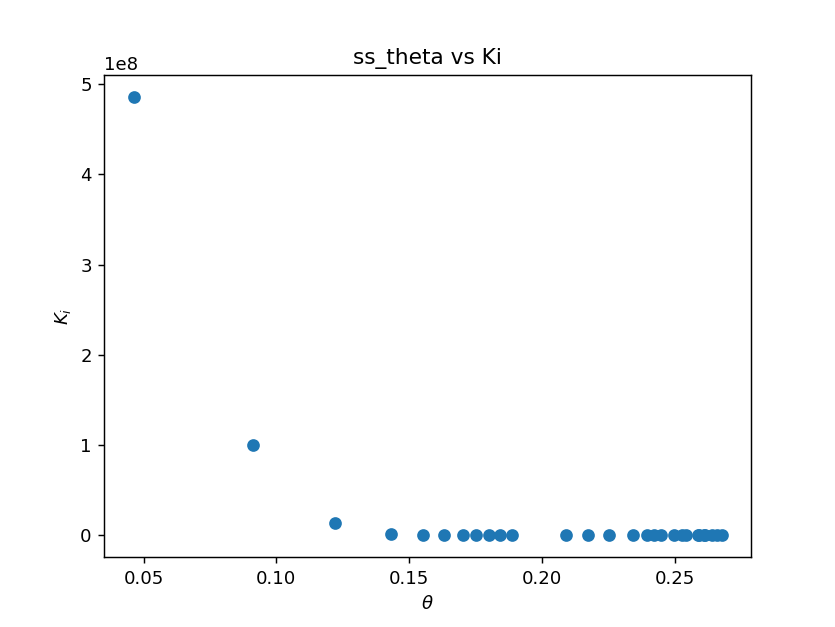

Text(0.5, 0, '$\\theta$')

In [10]:
plt.figure(dpi = 100)
plt.title('ss_theta vs Ki')
plt.scatter(df['theta'], df['Ki'])
plt.ylabel(r'$K_i$')
plt.xlabel(r'$\theta$')

In [11]:
X = df[['theta']]
y = df['Ki']
y_true = y
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22, 1), (6, 1), (22,), (6,))

In [24]:
from gplearn.functions import make_function

def exp(x1):
    f = np.exp(x1)
    return f

def pow_2(x1):
    f = x1**2
    return f

def pow_3(x1):
    f = x1**3
    return f

exp = make_function(function=exp,name='exp',arity=1)
pow_2 = make_function(function=pow_2,name='pow2',arity=1)# add the new function to the function_set
pow_3 = make_function(function=pow_3,name='pow3',arity=1)# add the new function to the function_set

function_set = ['add', 'sub', 'mul', 'div','cos','sin','neg','inv',exp, pow_2,pow_3]



In [25]:
est_gp = SymbolicRegressor(population_size=500000,function_set=function_set,const_range=(0.0,0.0),
                           generations=20, stopping_criteria=0.01,metric='rmse',
                           p_crossover=0.85, p_subtree_mutation=0.05, ##
                           p_hoist_mutation=0.05, p_point_mutation=0.05, ##need to add up to 1
                           max_samples=0.8, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)

In [ ]:
t0 = time.time()
est_gp.fit(X_train, y_train)
print('Time to fit:', time.time() - t0, 'seconds')

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_6954/4049802405.py:4: RuntimeWarning: overflow encountered in exp
  f = np.exp(x1)
/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_6954/4049802405.py:12: RuntimeWarning: overflow encountered in power
  f = x1**3
/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/gplearn/fitness.py:137: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.average(((y_pred - y) ** 2), weights=w))
/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:527: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/gplearn/functions.py:46: RuntimeWarning: invalid value encountered in sin
  return self.function(*args)
/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/gplearn/functions.py:46: RuntimeWarning: invalid value encountered in multiply
  return self.function(

   0    11.49              nan        5              nan              nan     61.45m


/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/gplearn/functions.py:127: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)
/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/gplearn/functions.py:46: RuntimeWarning: invalid value encountered in add
  return self.function(*args)


   1    11.44              nan       19              nan              nan     69.94m
   2    14.49              nan       54              nan              nan     66.89m
   3    21.56              nan       14              nan              nan     70.39m
   4    25.26              nan       33              nan              nan     75.42m
   5    28.79              nan        8              nan              nan     75.56m
   6    32.29              nan       14              nan              nan     74.08m
   7    35.86              nan       48              nan              nan     79.33m
   8    39.52              nan       29              nan              nan     73.66m
   9    43.17              nan       14              nan              nan     72.34m


/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


  10    47.01              nan       46              nan              nan     84.42m


/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/gplearn/functions.py:46: RuntimeWarning: overflow encountered in subtract
  return self.function(*args)


  11    50.85              nan       71              nan              nan     78.92m
  12    54.86              nan       35              nan              nan     77.72m
  13    59.01              nan       89              nan              nan     68.02m
  14    63.29              nan       43              nan              nan    210.09m


In [ ]:
t0 = time.time()
y_gp1 = est_gp.predict(X_test)
print('Time to predict:', time.time() - t0, 'seconds')

In [ ]:
score_gp1 = est_gp.score(X_test, y_test)
print('R2:', score_gp1)

In [ ]:
converter = {
    'add': lambda x, y : x + y,
    'sub': lambda x, y : x - y,
    'mul': lambda x, y : x*y,
    'div': lambda x, y : x/y,
    'sqrt': lambda x : x**0.5,
    'log': lambda x : log(x),
    'abs': lambda x : abs(x),
    'neg': lambda x : -x,
    'inv': lambda x : 1/x,
    'max': lambda x, y : max(x, y),
    'min': lambda x, y : min(x, y),
    'sin': lambda x : sin(x),
    'cos': lambda x : cos(x),
    'pow': lambda x, y : x**y,
}

In [ ]:
next_e = sympify(str(est_gp._program), locals=converter)
next_e

In [ ]:
y_gp = est_gp.predict(X_test)
score_gp1 = est_gp.score(X_test, y_test)
score_gp1

In [ ]:
fig = plt.figure(constrained_layout=False, dpi=100)
gs = fig.add_gridspec(nrows=7, ncols=1)
f_ax1 = fig.add_subplot(gs[0:5,0])
plt.title('H (z) comparison')
plt.scatter(X_test, y_test, label = 'True function')
plt.scatter(X_test, y_gp1, marker = 'v', s = 10, label = 'Symbolic function')
plt.legend()
plt.ylabel('H (z)')
f_ax2 = fig.add_subplot(gs[5:7, 0])
plt.scatter(X_test, 1. - y_gp1/y_test, marker = 's', s = 10)
plt.ylabel('Residual')
plt.xlabel('z')

In [ ]:
##Step4: Ret#Simulation times from each kMC simulation
t0,tf = 0,750.000000000102

In [ ]:
%%time
#Performing SS MIKI MKM simulations for lateral case
from main import *
MKMCD = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKMCD.Thermo_Constraint = 'OFF'
MKMCD.set_limits_of_integration(t0,tf)
colmn = len(MKMCD.Stoich.iloc[0,1:]) - len(MKMCD.P) #Number of columns (i.e rate coefficients = no. of surface species being investigated)
row = len(MKMCD.k) #number of rows = number of rate constants (i.e reaction steps)
MKM_SS_covg_LAT = []
Prs = Prs_lat #Lateral pressures## TO BE PREDICTED###########################################################
for i in np.arange(len(Prs)):
    MKMCD.set_rxnconditions(Pr=[Prs[i]])
    MKM_SS_covg_LAT = np.append(MKM_SS_covg_LAT,MKMCD.get_SS_coverages(print_warning=True)[0])    

In [ ]:
##Step 4-> Getting predicted _f(theta)
Ki_lateral_pred = est_gp.predict(np.array([MKM_SS_covg_LAT]).T)

##Step6-> Calculating predicted theta
ML_theta_pred = []
for i in np.arange(len(Prs)):
    ML_theta_pred.append((Ki_lateral_pred[i]*Prs[i])/(1+(Ki_lateral_pred[i]*Prs[i])))

In [ ]:
plt.figure()
plt.semilogx(Prs,ML_theta_pred,'-',label='ML lateral prediction')
plt.semilogx(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.semilogx(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.semilogx(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
# plt.semilogx(Prs,MKM_SS_covg_LAT,'-',label='MKM isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()

In [ ]:
plt.figure()
plt.plot(Prs,ML_theta_pred,'-',label='ML lateral prediction')
plt.plot(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.plot(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.plot(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
# plt.semilogx(Prs,MKM_SS_covg_LAT,'-',label='MKM isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()